In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import timeit
import numpy as np

In [2]:


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
class Encoder(nn.Module):
    def __init__(self, n_input=784, n_latent=2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(n_input,512)
        self.fc2 = nn.Linear(512, n_latent)
        
    def forward(self,x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
class Decoder(nn.Module):
    def __init__(self, n_input=784, n_latent=2):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(n_latent, 512)
        self.fc2 = nn.Linear(512, n_input)
        
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z.reshape(-1,1,28,28)
    
class Autoencoder(nn.Module):
    def __init__(self, n_input=784, n_latent = 2):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(n_input, n_latent)
        self.decoder = Decoder(n_input, n_latent)
        
    def forward(self,x):
        z = self.encoder(x)
        return self.decoder(z) 

In [4]:
def train(autoencoder, data, epochs = 20):
    print("Start training")
    start_time = timeit.default_timer()
    opt = torch.optim.Adam(autoencoder.parameters())
    for e in range(epochs):
        epoch_loss = 0
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_recon = autoencoder(x)
            loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
#             loss = ((x - x_recon)**2).sum()
            loss.backward()
            epoch_loss += loss.mean()
            opt.step()
        current_time = timeit.default_timer()
        print(f"Done {e}th epoch, Loss: {epoch_loss} Time: {current_time - start_time:.0f}" )
    return autoencoder

In [5]:
latent_dims = 2
input_dims = 784

autoencoder = Autoencoder(input_dims, latent_dims)

data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)


Start training
Done 0th epoch, Loss: 10748662.0 Time: 10
Done 1th epoch, Loss: 9559900.0 Time: 20
Done 2th epoch, Loss: 9316968.0 Time: 31
Done 3th epoch, Loss: 9175484.0 Time: 41
Done 4th epoch, Loss: 9076767.0 Time: 51
Done 5th epoch, Loss: 9000445.0 Time: 61
Done 6th epoch, Loss: 8931063.0 Time: 71
Done 7th epoch, Loss: 8881258.0 Time: 81
Done 8th epoch, Loss: 8830069.0 Time: 91
Done 9th epoch, Loss: 8791066.0 Time: 101
Done 10th epoch, Loss: 8753341.0 Time: 111
Done 11th epoch, Loss: 8714552.0 Time: 122
Done 12th epoch, Loss: 8684604.0 Time: 132
Done 13th epoch, Loss: 8654934.0 Time: 142
Done 14th epoch, Loss: 8625648.0 Time: 152
Done 15th epoch, Loss: 8599856.0 Time: 162
Done 16th epoch, Loss: 8578232.0 Time: 172
Done 17th epoch, Loss: 8558278.0 Time: 183
Done 18th epoch, Loss: 8536355.0 Time: 193
Done 19th epoch, Loss: 8516555.0 Time: 205


In [17]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:,0], z[:,1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
        plt.savefig('output/ae_distribution.png')

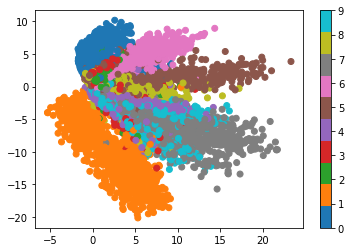

In [18]:
plot_latent(autoencoder,data)

In [19]:
def plot_reconstructed(autoencoder, r0=(-5, 25), r1=(-20, 10), n=50):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x,y]]).to(device)
            x_recon = autoencoder.decoder(z)
            x_recon = x_recon.reshape(28,28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_recon
    plt.figure(figsize = (20,20))
    plt.imshow(img, extent=[*r0,*r1], aspect='auto')
    plt.savefig('output/ae_sampling.png')

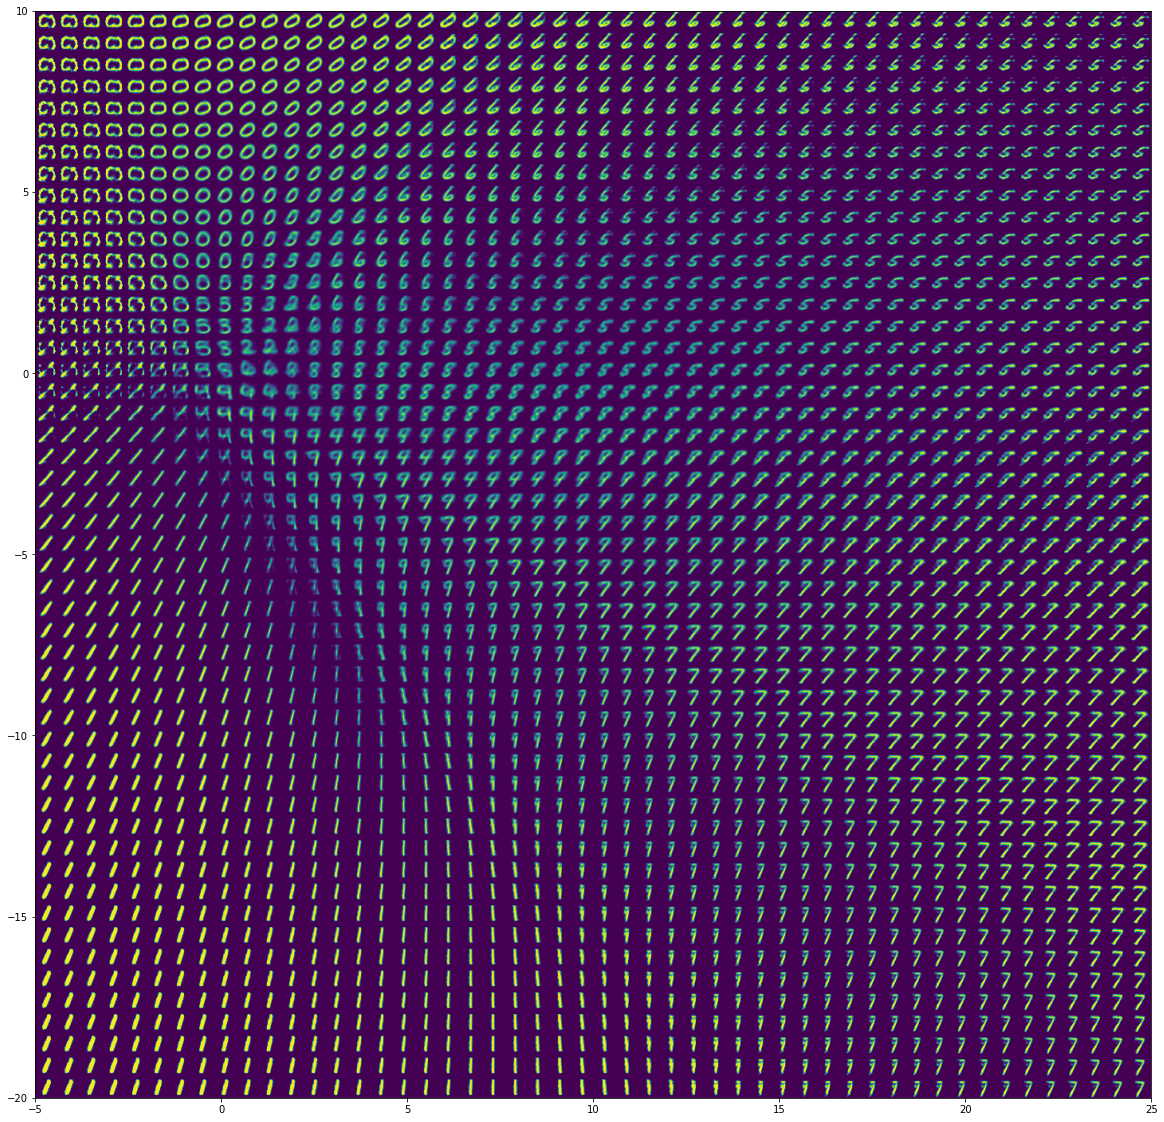

In [20]:
plot_reconstructed(autoencoder)